In [9]:
from cgeniepy.ecology import EcoModel
import xarray as xr
import numpy as np
from cgeniepy.array import GriddedData
GriddedData.modify_in_place=False
## plot pft richness maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

new_ls_mask = xr.load_dataarray("../masked_array.nc")

def mask_arctic(input_data):
    "apply the new land-sea mask to the data"
    input_data = input_data * new_ls_mask
    return input_data

exp1 = EcoModel("../model/muffin.u067bc.PO4.EXP1", gemflag=['biogem', 'ecogem'])
exp2 = EcoModel("../model/muffin.u067bc.PO4.EXP2", gemflag=['biogem', 'ecogem'])
exp3 = EcoModel("../model/muffin.u067bc.PO4.EXP3", gemflag=['biogem', 'ecogem'])
exp4 = EcoModel("../model/muffin.u067bc.PO4.EXP4", gemflag=['biogem', 'ecogem'])
exp5 = EcoModel("../model/muffin.u067bc.PO4.EXP5", gemflag=['biogem', 'ecogem'])

In [11]:
def pft_change(model):

    time_steps = model.get_pft(1).data.time

    #carbon_thresholds = model.eco_pars()['q_C']

    ## recalculate because foram use a different method
    qcarbon_a = model.get_config('ECOGEM')['qcarbon_a']
    qcarbon_b = model.get_config('ECOGEM')['qcarbon_b']
    volume = model.eco_pars()['volume']
    carbon_thresholds = qcarbon_a * volume ** qcarbon_b

    ## counting from 0
    phyto_index = np.arange(0,32)
    zoo_index = np.arange(32,64)
    mixo_index = np.arange(64,96)
    foram_index = np.arange(96,112)

    ## diversity (no. of PFTs) map

    model_mask = model.grid_mask()

    phyto_rich, zoo_rich, mixo_rich, foram_rich = [], [], [], []

    for i in range(len(carbon_thresholds)):
        pft = model.get_pft(i+1)
        threshold = carbon_thresholds[i]    
        ## filter out the species with biomass less than threshold    
        pft_presence = xr.where(pft> threshold, 1, 0.0)
        if i in phyto_index:
            phyto_rich.append(pft_presence)
        elif i in zoo_index:
            zoo_rich.append(pft_presence)
        elif i in mixo_index:
            mixo_rich.append(pft_presence)
        elif i in foram_index:
            foram_rich.append(pft_presence)

    ## sum over PFT dimension
    phyto_rich = xr.concat(phyto_rich, dim='pft') * model_mask
    zoo_rich = xr.concat(zoo_rich, dim='pft') * model_mask
    mixo_rich = xr.concat(mixo_rich, dim='pft')* model_mask
    foram_rich = xr.concat(foram_rich, dim='pft')*model_mask
    total_pft = phyto_rich.sum(dim='pft') + zoo_rich.sum(dim='pft') +mixo_rich.sum(dim='pft') +foram_rich.sum(dim='pft')

    total_pft = total_pft *model_mask
    total_pft = GriddedData(total_pft, attrs={'long_name': 'Total PFTs',  'units': ''})
    return total_pft

In [12]:
solar_effect = pft_change(exp1)
co2_effect = pft_change(exp2)
total_effect = pft_change(exp3)
temp_effect = pft_change(exp4)
par_effect = pft_change(exp5)

In [13]:
par_effect = mask_arctic(par_effect)
temp_effect = mask_arctic(temp_effect)
co2_effect = mask_arctic(co2_effect)
solar_effect = mask_arctic(solar_effect)
total_effect = mask_arctic(total_effect)

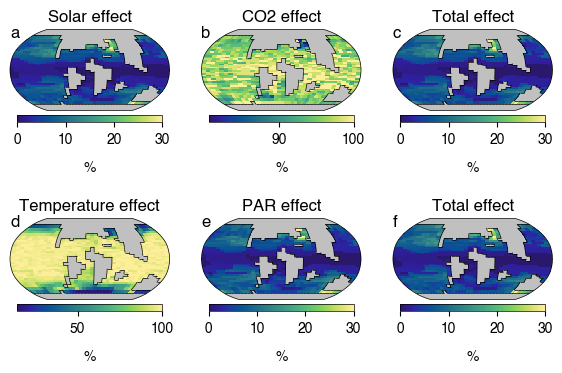

In [14]:
fig, axs = plt.subplots(2, 3,figsize=(7, 4.5), subplot_kw={'projection': ccrs.Robinson()})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
from cmap import Colormap

cmap = Colormap( 'cmocean:haline').to_mpl()

input_data = [solar_effect, co2_effect, total_effect, par_effect, temp_effect,total_effect]
title = ['Solar effect', 'CO2 effect', 'Total effect', 'Temperature effect', 'PAR effect', 'Total effect']
vmaxs = [0.3,1.0, 0.3, 1.0, 0.3, 0.3]
for i, ax in enumerate(axs.flat):
    extinction_rate = input_data[i].isel(time=-1)/input_data[i].isel(time=0)*100
    subplot = extinction_rate.to_GriddedDataVis()
    subplot.aes_dict['colorbar_label_kwargs']['label'] = "%"
    # subplot.aes_dict['colorbar_label_kwargs']['labelpad'] = 0.2
    
    subplot.plot(ax=ax, cmap=cmap, colorbar=True, outline=True, vmax=vmaxs[i]*100)
    ax.set_title(title[i])
    # add the letter label
    ax.text(0.0, 0.9, chr(97+i), transform=ax.transAxes, 
            size=12, weight='bold')

fig.savefig("../output/extinction_driver.png", dpi=300, bbox_inches='tight')